<a href="https://colab.research.google.com/github/silviolima07/Kaggle/blob/master/Nota_MT_Enem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ENEM 2016

## Prever a nota da prova de Matemática de quem fez a prova

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.pylabtools import figsize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200) 
pd.set_option('display.max_rows', 200)
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import metrics
# Imputing missing values and scaling values
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, skew

In [ ]:
# Funcao para reducao da memoria utilizada
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Funcao para realizar a leitura dos arquivos
def read_data():
     
        print('Carregando os arquivos...')
        train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Codenation-enen2/train.csv', encoding='utf-8')
        test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/Codenation-enen2/test.csv', encoding='utf-8')
        train = reduce_mem_usage(train)
        test = reduce_mem_usage(test)
    
        return train, test

### Leitura dos datasets

In [ ]:
# Leitura dos dados
train, test = read_data()

Carregando os arquivos...
Mem. usage decreased to  8.24 Mb (52.9% reduction)
Mem. usage decreased to  0.72 Mb (56.4% reduction)


In [ ]:
train.shape

(13730, 167)

In [ ]:
test.shape

(4576, 47)

In [ ]:
# Colunas presentes no dataset train
# train possue 167 variaveis

train.drop('Unnamed: 0', axis=1, inplace=True)
train.columns

Index(['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=166)

In [ ]:
# Colunas presentes no dataset test
# Total de 47 variaveis
test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [ ]:
# O modelo irá usar as variaveis presentes em test em seu pre-processamento e treinamento
train=train[['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'IN_TREINEIRO',
       'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ',
       'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE',
       'IN_IDOSO', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047',"NU_NOTA_MT"]]


### Análise da correlação entre as variáveis numéricas com NU_NOTA_MT

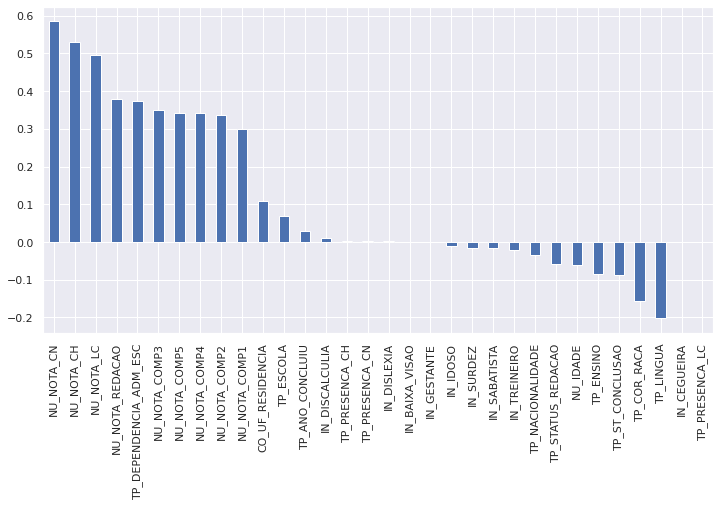

In [ ]:
corr_with_NU_NOTA_MT = train.corr()["NU_NOTA_MT"].sort_values(ascending=False)
plt.figure(figsize=(12,6))
corr_with_NU_NOTA_MT.drop("NU_NOTA_MT").plot.bar()
plt.show();

In [ ]:
# Checar as correlações do dataset com uma variável escolhida
def checar_var_corr(df,var):
  features_corr = df.corr().abs().round(2)
  print(features_corr[var].sort_values(ascending = False))

In [ ]:
checar_var_corr(train, "NU_NOTA_MT")


NU_NOTA_MT                1.00
NU_NOTA_CN                0.58
NU_NOTA_CH                0.53
NU_NOTA_LC                0.49
NU_NOTA_REDACAO           0.38
TP_DEPENDENCIA_ADM_ESC    0.37
NU_NOTA_COMP3             0.35
NU_NOTA_COMP5             0.34
NU_NOTA_COMP4             0.34
NU_NOTA_COMP2             0.34
NU_NOTA_COMP1             0.30
TP_LINGUA                 0.20
TP_COR_RACA               0.16
CO_UF_RESIDENCIA          0.11
TP_ST_CONCLUSAO           0.09
TP_ENSINO                 0.09
TP_ESCOLA                 0.07
NU_IDADE                  0.06
TP_STATUS_REDACAO         0.06
TP_NACIONALIDADE          0.03
TP_ANO_CONCLUIU           0.03
IN_TREINEIRO              0.02
IN_SABATISTA              0.02
IN_SURDEZ                 0.02
IN_IDOSO                  0.01
IN_DISCALCULIA            0.01
TP_PRESENCA_CN            0.00
TP_PRESENCA_CH            0.00
IN_BAIXA_VISAO            0.00
IN_DISLEXIA               0.00
IN_GESTANTE               0.00
IN_CEGUEIRA                NaN
TP_PRESE

In [ ]:
train_3 = train[['TP_LINGUA','TP_COR_RACA','NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_COMP3','NU_NOTA_REDACAO', 
                 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN',    'TP_ST_CONCLUSAO', 'NU_NOTA_MT']]

In [ ]:
test_2 = test[['NU_INSCRICAO','TP_LINGUA','TP_COR_RACA','NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_COMP3','NU_NOTA_REDACAO', 
                 'NU_NOTA_LC', 'NU_NOTA_CH', 'NU_NOTA_CN',    'TP_ST_CONCLUSAO']]

In [ ]:
train_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TP_LINGUA        13730 non-null  int8   
 1   TP_COR_RACA      13730 non-null  int8   
 2   NU_NOTA_COMP4    10133 non-null  float16
 3   NU_NOTA_COMP5    10133 non-null  float16
 4   NU_NOTA_COMP3    10133 non-null  float16
 5   NU_NOTA_REDACAO  10133 non-null  float16
 6   NU_NOTA_LC       10133 non-null  float16
 7   NU_NOTA_CH       10341 non-null  float16
 8   NU_NOTA_CN       10341 non-null  float16
 9   TP_ST_CONCLUSAO  13730 non-null  int8   
 10  NU_NOTA_MT       10133 non-null  float16
dtypes: float16(8), int8(3)
memory usage: 254.9 KB


In [ ]:

train = train_3
test = test_2


In [ ]:
# Checar valores nulos
missing_values_table(train)

Your selected dataframe has 11 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
NU_NOTA_COMP4,3597,26.2
NU_NOTA_COMP5,3597,26.2
NU_NOTA_COMP3,3597,26.2
NU_NOTA_REDACAO,3597,26.2
NU_NOTA_LC,3597,26.2
NU_NOTA_MT,3597,26.2
NU_NOTA_CH,3389,24.7
NU_NOTA_CN,3389,24.7


In [ ]:
# Dataset train
# Get the columns with > 50% missing
missing_df = missing_values_table(train);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
print(list(missing_columns))
# Drop the columns
train = train.drop(columns = list(missing_columns))



Your selected dataframe has 11 columns.
There are 8 columns that have missing values.
We will remove 0 columns.
[]


In [ ]:
# Dataset test
# Get the columns with > 50% missing
missing_df = missing_values_table(test);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
print(list(missing_columns))
# Drop the columns
test = test.drop(columns = list(missing_columns))

Your selected dataframe has 11 columns.
There are 7 columns that have missing values.
We will remove 0 columns.
[]


In [ ]:
train.columns

Index(['TP_LINGUA', 'TP_COR_RACA', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
       'NU_NOTA_COMP3', 'NU_NOTA_REDACAO', 'NU_NOTA_LC', 'NU_NOTA_CH',
       'NU_NOTA_CN', 'TP_ST_CONCLUSAO', 'NU_NOTA_MT'],
      dtype='object')

In [ ]:
test.columns

Index(['NU_INSCRICAO', 'TP_LINGUA', 'TP_COR_RACA', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_COMP3', 'NU_NOTA_REDACAO', 'NU_NOTA_LC',
       'NU_NOTA_CH', 'NU_NOTA_CN', 'TP_ST_CONCLUSAO'],
      dtype='object')

In [ ]:
# No dataset test a coluna 'NU_INSCRICAO' será removida, pois não é relevante e não esta sendo usada no treinamento.
test.drop(['NU_INSCRICAO'], axis=1, inplace=True)

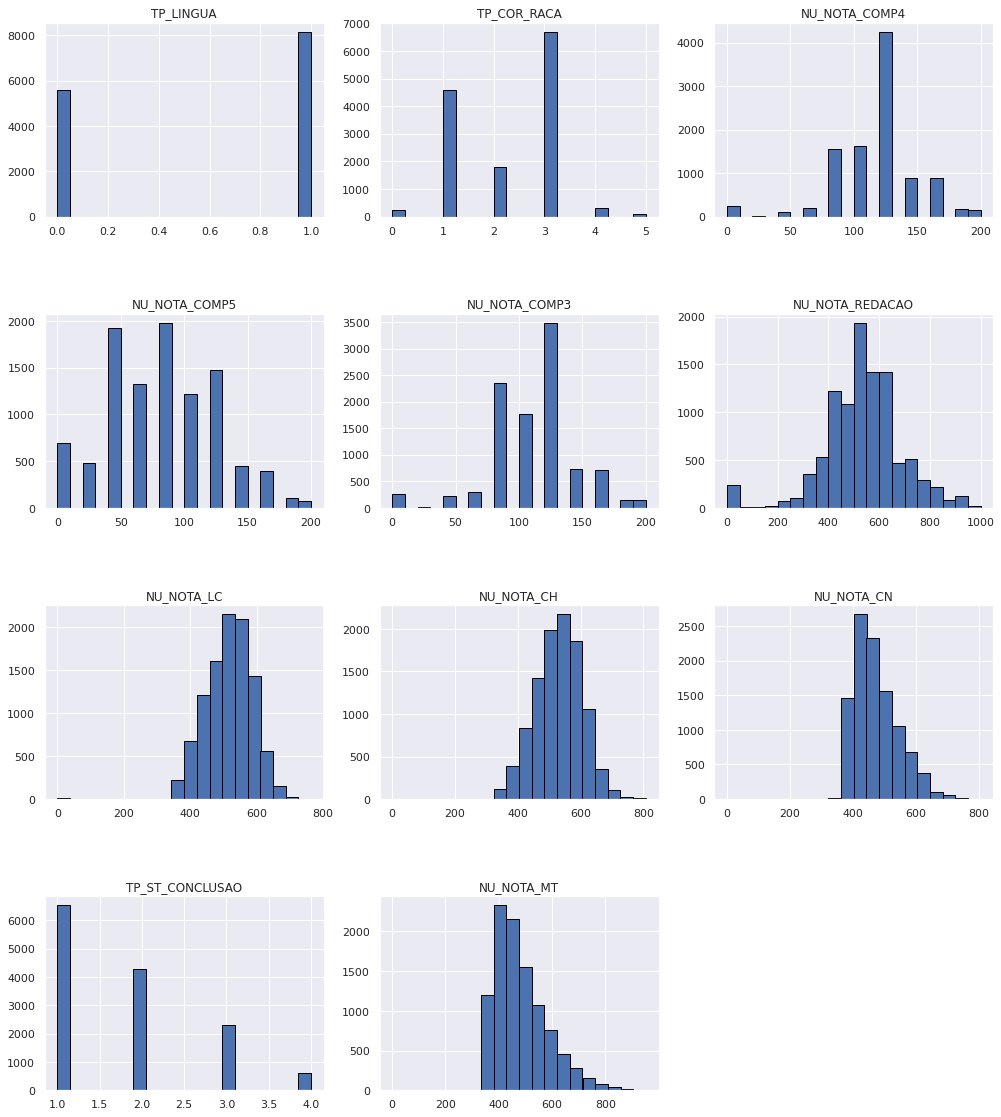

In [ ]:
# Análise dos dados em train
columns = train.columns[:16]
plt.subplots(figsize=(17,25))
length=len(columns)
for i,j in zip(columns,range(length)):
    plt.subplot((length/2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    train[i].hist(bins=20,edgecolor='black')
    plt.title(i)
plt.show()

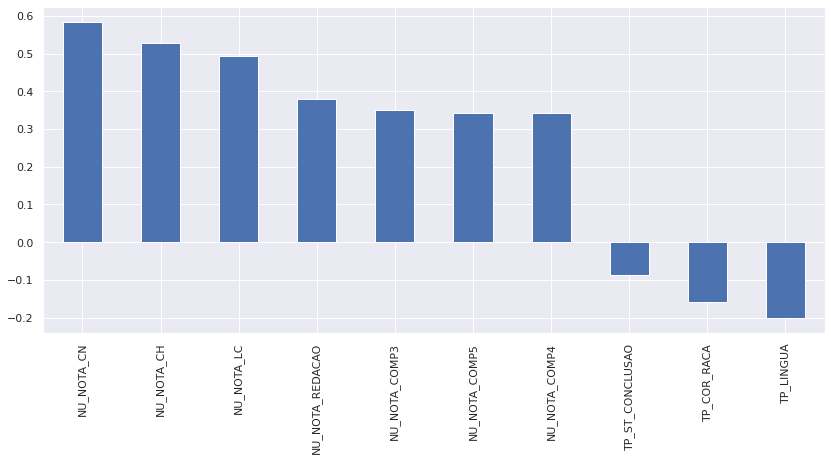

In [ ]:
corr_with_NU_NOTA_MT = train.corr()["NU_NOTA_MT"].sort_values(ascending=False)
plt.figure(figsize=(14,6))
corr_with_NU_NOTA_MT.drop("NU_NOTA_MT").plot.bar()
plt.show();

In [ ]:
# Dataset train possue ainda dados nulos ou missing.
train.isnull().sum()

TP_LINGUA             0
TP_COR_RACA           0
NU_NOTA_COMP4      3597
NU_NOTA_COMP5      3597
NU_NOTA_COMP3      3597
NU_NOTA_REDACAO    3597
NU_NOTA_LC         3597
NU_NOTA_CH         3389
NU_NOTA_CN         3389
TP_ST_CONCLUSAO       0
NU_NOTA_MT         3597
dtype: int64

In [ ]:
# Dataset train
# Aplicar log1p a coluna target. Isto auxilia na performance pois ajusta o formato da distribuição, ficando mais próxima de uma normal.
train["NU_NOTA_MT"] = np.log1p(train["NU_NOTA_MT"])

# log transform skewed numeric features:
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

train[skewed_feats] = np.log1p(train[skewed_feats])
train = pd.get_dummies(train)
train = train.fillna(train.mean())

X = train.drop(['NU_NOTA_MT'], axis = 1)

y = train['NU_NOTA_MT']

In [ ]:
# Dataset test

# log transform skewed numeric features:
numeric_feats = test.dtypes[test.dtypes != "object"].index

skewed_feats = test[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

test[skewed_feats] = np.log1p(test[skewed_feats])
test = pd.get_dummies(test)
test = test.fillna(test.mean())

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = 0.2, random_state = 0)

### Modelos usando o algoritmo XGBRegressor

In [ ]:
xgb_model1 = XGBRegressor(n_estimators=5000)
xgb_model1.fit(X_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X_train)
y_pred1 = xgb_model1.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred1, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred1))
train_mse1 = mean_squared_error(y_train_pred1, y_train)
test_mse1 = mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

[04:35:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9986562267403276
Test r2 score:  0.9933211038877406
Train RMSE: 0.0736
Test RMSE: 0.1639


In [ ]:
xgb_model2 = XGBRegressor(n_estimators=1000)
xgb_model2.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred2 = xgb_model2.predict(X_train)
y_pred2 = xgb_model2.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred2, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred2))
train_mse2 = mean_squared_error(y_train_pred2, y_train)
test_mse2 = mean_squared_error(y_pred2, y_test)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
print('Train RMSE: %.4f' % train_rmse2)
print('Test RMSE: %.4f' % test_rmse2)

[04:35:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9939686050101768
Test r2 score:  0.9959435258844404
Train RMSE: 0.1555
Test RMSE: 0.1277


In [ ]:
xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', r2_score(y_train_pred3, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred3))
train_mse3 = mean_squared_error(y_train_pred3, y_train)
test_mse3 = mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)

[04:36:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9942579545855537
Test r2 score:  0.9959456784748616
Train RMSE: 0.1517
Test RMSE: 0.1277


In [ ]:
data = {'Modelo':  ['xgb_model1', 'xgb_model2','xgb_model3'],
        'Train r2 score': [r2_score(y_train_pred1, y_train), r2_score(y_train_pred2, y_train),r2_score(y_train_pred3, y_train)],
        'Test r2 score': [r2_score(y_test, y_pred1),r2_score(y_test, y_pred2),r2_score(y_test, y_pred2)],
        'Train Mse': [mean_squared_error(y_train_pred1, y_train),mean_squared_error(y_train_pred2, y_train), mean_squared_error(y_train_pred3, y_train) ],
        'Test Mse': [mean_squared_error(y_pred1, y_test),mean_squared_error(y_pred2, y_test), mean_squared_error(y_pred3, y_test) ],
        'Train Rmse': [np.sqrt(mean_squared_error(y_train_pred1, y_train)), np.sqrt(mean_squared_error(y_train_pred2, y_train)), np.sqrt( mean_squared_error(y_train_pred3, y_train))],
        'Test Rmse': [np.sqrt(mean_squared_error(y_pred1, y_test)), np.sqrt(mean_squared_error(y_pred2, y_test)), np.sqrt( mean_squared_error(y_pred3, y_test))]
        }

df = pd.DataFrame (data, columns = ['Modelo','Train r2 score','Test r2 score', 'Train Mse', 'Test Mse', 'Train Rmse', 'Test Rmse'])
df

,Modelo,Train r2 score,Test r2 score,Train Mse,Test Mse,Train Rmse,Test Rmse
0,xgb_model1,0.998656,0.993321,0.005421,0.026848,0.073630,0.163854
1,xgb_model2,0.993969,0.995944,0.024165,0.016306,0.155450,0.127696
2,xgb_model3,0.994258,0.995944,0.023023,0.016298,0.151733,0.127662


In [ ]:
# Aplicar modelo no dataset test
test_preds = xgb_model1.predict(test)
# Recuperar número original
test_preds_2 = np.expm1(test_preds)

In [ ]:
# The lines below shows how to save predictions in format used for competition scoring
# Just uncomment them.

output = pd.DataFrame({'NU_INSCRICAO': test_2.NU_INSCRICAO,
                       'NU_NOTA_MT': test_preds_2})
output.to_csv('answer.csv', index=False)

print("Done")

Done
